# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from loadcreon import LoadCreon
from creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from semisuperhelper import SemiSupervisedHelper
from pnuwrapper import PNUWrapper
from jeffsearchcv import JeffRandomSearchCV
from nestedcross import NestedCV, rerun_nested_for_estimator, rerun_nested_for_scoring
from frankenscorer import FrankenScorer, extract_scores_from_nested, extract_score_grid
from searchrf import save_search, load_search

In [3]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

In [5]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

## Set up randomized search parameters

In [6]:
rf_param_search = {
 'base_estimator__bootstrap': [True, False],
 'base_estimator__class_weight': [None,'balanced','balanced_subsample'],
 'base_estimator__criterion': ['gini','entropy'],
 'base_estimator__max_depth': [None] + list(range(2,100)),
 'base_estimator__max_features': ['sqrt','log2',None] + list(range(5,100)),
 'base_estimator__min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100],
 'base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,
                                                        0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
 'base_estimator__n_estimators': sp.stats.randint(low=10, high=500),
 'pu_learning': [True, False],
 'num_unlabeled':sp.stats.randint(low=0, high=15000),
                  }

## Set up PNU Wrapper with Random Forest, then JeffSearchCV, then NestedCV

In [7]:
pnu = PNUWrapper(base_estimator=RandomForestClassifier(verbose=1), random_state=42)

In [8]:
jeffsearch = JeffRandomSearchCV(pnu, rf_param_search, n_iter=100, scoring=FrankenScorer('pu_mix_assumed_f1beta10'),
                                n_jobs=-1, cv=3, verbose=1, pre_dispatch=8)

#### 3x3 (x100) nested cross validation

In [9]:
nested_cross = NestedCV(jeffsearch, scoring=FrankenScorer('pu_mix_assumed_f1beta10'),
                        cv=3, random_state=77, use_same_random_state=True)

## Score the nested cross - 900 models!

In [10]:
scores = nested_cross.score(X_train.values, y=y_train.values, verbose=1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 76.4min finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   49.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   14.4s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   14.5s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 77.8min finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   50.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   14.4s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   14.5s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 42.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 77.9min finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   51.9s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   14.5s finished
[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   14.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 237.1min finished


## The scores of the 3 folds of the outer loop.  FrankenScorer for 100*f1beta=10 + PU

In [11]:
scores

(85.230536985467708, 81.532887669271602, 81.723859646111265)

In [12]:
save_search(nested_cross, './res/nested_cross_rf_large_20170210')

In [17]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0315663
assumed_brier_neg                                                   0.030774
assumed_f1                                                          0.139336
assumed_f1beta10                                                    0.704203
confusion_matrix_lab       [[252.666666667, 34.6666666667], [129.66666666...
confusion_matrix_un        [[111816.666667, 5145.33333333], [129.66666666...
fn_confusion_matrix_lab                                              129.667
fn_confusion_matrix_un                                               129.667
fp_confusion_matrix_lab                                              34.6667
fp_confusion_matrix_un                                               5145.33
labeled_acc                                                         0.805289
labeled_avg_prec                                                    0.922949
labeled_brier                                                       0.160676

# Let's dive in and see the parameters for one of the best models

In [19]:
all_scores = [extract_score_grid(est) for est in nested_cross.estimators_]

In [22]:
best_clf_idx = [s.mean_pu_mix_assumed_f1beta10_test.idxmax() for s in all_scores]

In [23]:
[est.cv_results_['params'][best_idx] for est, best_idx in zip(nested_cross.estimators_, best_clf_idx)]

[{'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced_subsample',
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 31,
  'base_estimator__max_features': 68,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 298,
  'num_unlabeled': 12743,
  'pu_learning': True},
 {'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced_subsample',
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 31,
  'base_estimator__max_features': 68,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 298,
  'num_unlabeled': 12743,
  'pu_learning': True},
 {'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced_subsample',
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 31,
  'base_estimator__max_features': 68,
  'base_estimator__min_samples_l

## Let's see what feature importance looks like for this specific estimator

In [29]:
all_feature_importances = [est.best_estimator_.feature_importances_ for est in nested_cross.estimators_]
feature_importances = np.mean(all_feature_importances, axis=0)
feature_table = pd.DataFrame(feature_importances, index=X_test.columns).sort_values(by=0, ascending=False)

In [30]:
feature_table

,0
DIAG_FLAG4_Sum,0.263904
DIAG_FLAG5_Sum,0.152854
ndc_cat58_Sum,0.050259
age,0.027597
CPT_FLAG9_Sum,0.022664
ndc_cat87_Sum,0.022056
DIAG_FLAG75_Sum,0.020480
CPT_FLAG43_Sum,0.014266
ndc_cat54_Sum,0.013730
ndc_cat85_Sum,0.013518


## Let's see what happens when use assumed_fbeta10 instead

In [46]:
nested_cross, new_estimators = rerun_nested_for_scoring(nested_cross, 'assumed_f1beta10', X=X_train.values, y=y_train.values,
                                        how='max', n_jobs=-1, verbose=1, return_estimators=True)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   36.2s finished


In [47]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0591336
assumed_brier_neg                                                  0.0587657
assumed_f1                                                          0.100699
assumed_f1beta10                                                    0.710042
confusion_matrix_lab       [[245.0, 42.3333333333], [106.333333333, 450.3...
confusion_matrix_un        [[109022.333333, 7939.66666667], [106.33333333...
fn_confusion_matrix_lab                                              106.333
fn_confusion_matrix_un                                               106.333
fp_confusion_matrix_lab                                              42.3333
fp_confusion_matrix_un                                               7939.67
labeled_acc                                                          0.82386
labeled_avg_prec                                                    0.924576
labeled_brier                                                       0.139815

In [48]:
all_scores = [extract_score_grid(est) for est in nested_cross.estimators_]

In [49]:
best_clf_idx = [s.mean_assumed_f1beta10_test.idxmax() for s in all_scores]

In [50]:
[est.cv_results_['params'][best_idx] for est, best_idx in zip(nested_cross.estimators_, best_clf_idx)]

[{'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced',
  'base_estimator__criterion': 'gini',
  'base_estimator__max_depth': 45,
  'base_estimator__max_features': 81,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_samples_split': 0.005,
  'base_estimator__n_estimators': 86,
  'num_unlabeled': 6377,
  'pu_learning': True},
 {'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced',
  'base_estimator__criterion': 'gini',
  'base_estimator__max_depth': 45,
  'base_estimator__max_features': 81,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_samples_split': 0.005,
  'base_estimator__n_estimators': 86,
  'num_unlabeled': 6377,
  'pu_learning': True},
 {'base_estimator__bootstrap': True,
  'base_estimator__class_weight': 'balanced',
  'base_estimator__criterion': 'gini',
  'base_estimator__max_depth': 45,
  'base_estimator__max_features': 81,
  'base_estimator__min_samples_leaf': 7,
  'base_estimator__min_sam

In [51]:
all_feature_importances = [est.feature_importances_ for est in new_estimators]
feature_importances = np.mean(all_feature_importances, axis=0)
feature_table = pd.DataFrame(feature_importances, index=X_test.columns).sort_values(by=0, ascending=False)

In [52]:
feature_table

,0
DIAG_FLAG4_Sum,0.370699
DIAG_FLAG5_Sum,0.201527
ndc_cat58_Sum,0.051308
CPT_FLAG9_Sum,0.028310
DIAG_FLAG75_Sum,0.024374
ndc_cat87_Sum,0.023281
age,0.016663
DIAG_FLAG6_Sum,0.010648
CPT_FLAG43_Sum,0.009968
ndc_cat54_Sum,0.009053


## Lets see what unlabeled probability histogram looks like

In [55]:
probabs = nested_cross.estimators_[0].predict_proba(X_test.values)[:, 1]

[Parallel(n_jobs=1)]: Done 298 out of 298 | elapsed:   19.6s finished


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000014331358>]], dtype=object)

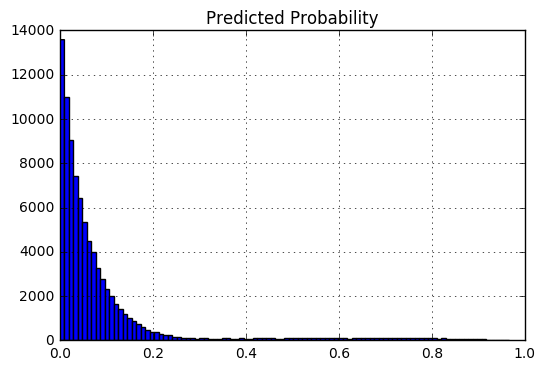

In [64]:
pd.DataFrame(probabs, columns=['Predicted Probability']).hist(bins=100)

In [65]:
new_probabs = new_estimators[0].predict_proba(X_test.values)[:, 1]

[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    5.1s finished


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001413C9E8>]], dtype=object)

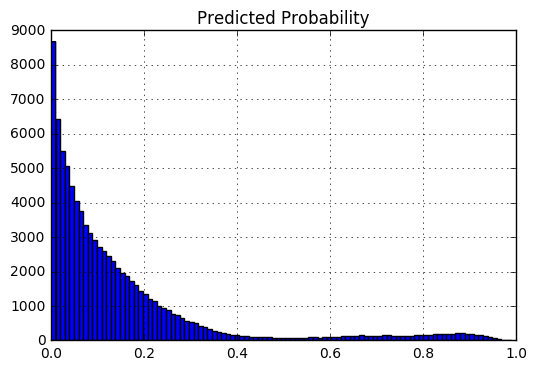

In [66]:
pd.DataFrame(new_probabs, columns=['Predicted Probability']).hist(bins=100)